In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

# 5. The ARMA Model

### Getting the Sunspot data into Python

In [3]:
# Import the dataframe

url1 = ('https://raw.githubusercontent.com/Apress/advanced-forecasting-python/refs/heads/main/Ch05_Sunspots_database.csv')

data = pd.read_csv(url1)

data.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [4]:
# Drop 'Unnamed: 0'
data.drop(columns='Unnamed: 0', inplace=True)

# Keep 'Date' as index as datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.dropna(subset=['Date'], inplace=True)
data.set_index('Date', inplace=True)

# Rename column
data.rename(columns={'Monthly Mean Total Sunspot Number': 'Sun'}, inplace=True)

data.head()

,Sun
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


In [5]:
data.tail()

,Sun
Date,
2019-08-31,0.5
2019-09-30,1.1
2019-10-31,0.4
2019-11-30,0.5
2019-12-31,1.6


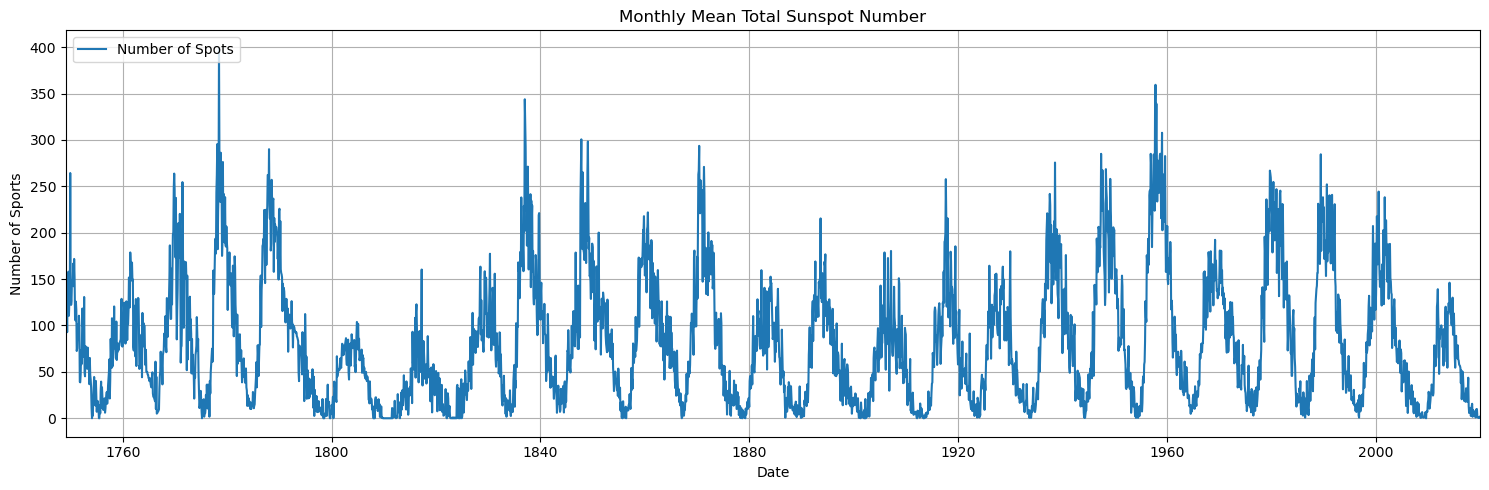

In [6]:
# Plot serie
plt.figure(figsize=(15, 5))                                      

plt.plot(data.index, data['Sun'], label='Number of Spots')     

plt.title('Monthly Mean Total Sunspot Number')                      
plt.xlabel('Date')                                        
plt.ylabel('Number of Sports')  
plt.xlim(pd.to_datetime('1749-01-31'), pd.to_datetime('2019-12-31'))
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show();

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Sun'])
print(result)

pvalue = result[1]

if pvalue < 0.05:
    print('Stationary')
else:
    print('Not stationary')

(-10.48086843266985, 1.2147141586504414e-18, 28, 3223, {'1%': -3.4323805665026175, '5%': -2.8624371819849372, '10%': -2.5672475896829807}, 29726.17960863342)
Stationary


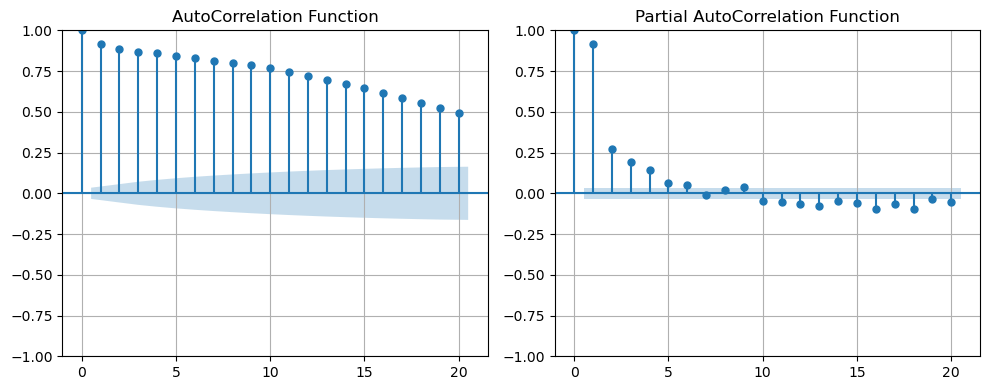

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(data['Sun'], ax=axes[0], lags=20)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(data['Sun'], ax=axes[1], lags=20)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

R2: 0.8609874464495804


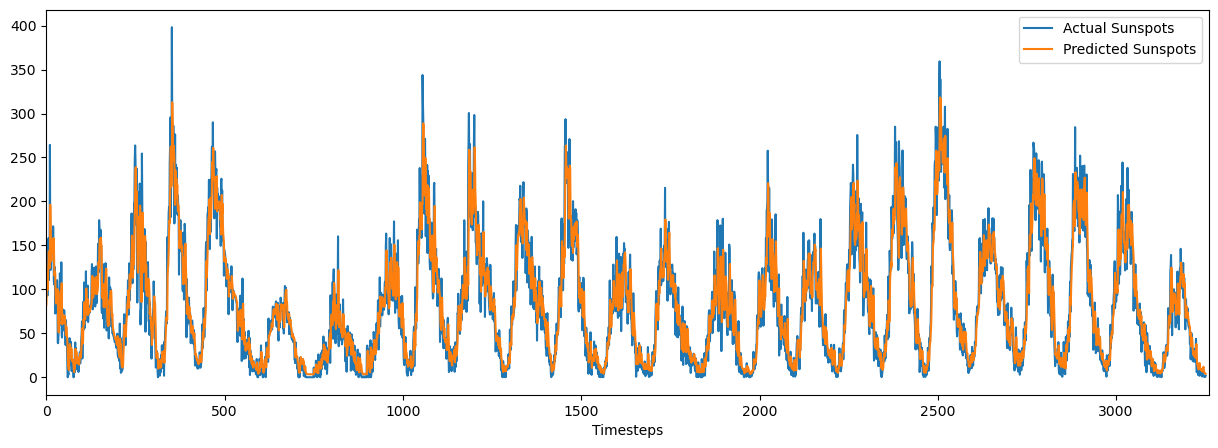

In [9]:
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA


# Forecast the first ARMA(1,1) model
mod = ARIMA(list(data['Sun']), order=(1,0,1))
res = mod.fit()
pred = res.predict()
print('R2:', r2_score(data, pred))

# Plot Graph
plt.figure(figsize=(15, 5))  
plt.plot(list(data['Sun']))
plt.plot(pred)
plt.legend(['Actual Sunspots', 'Predicted Sunspots'])
plt.xlabel('Timesteps')
plt.xlim(0,3260)
plt.show()

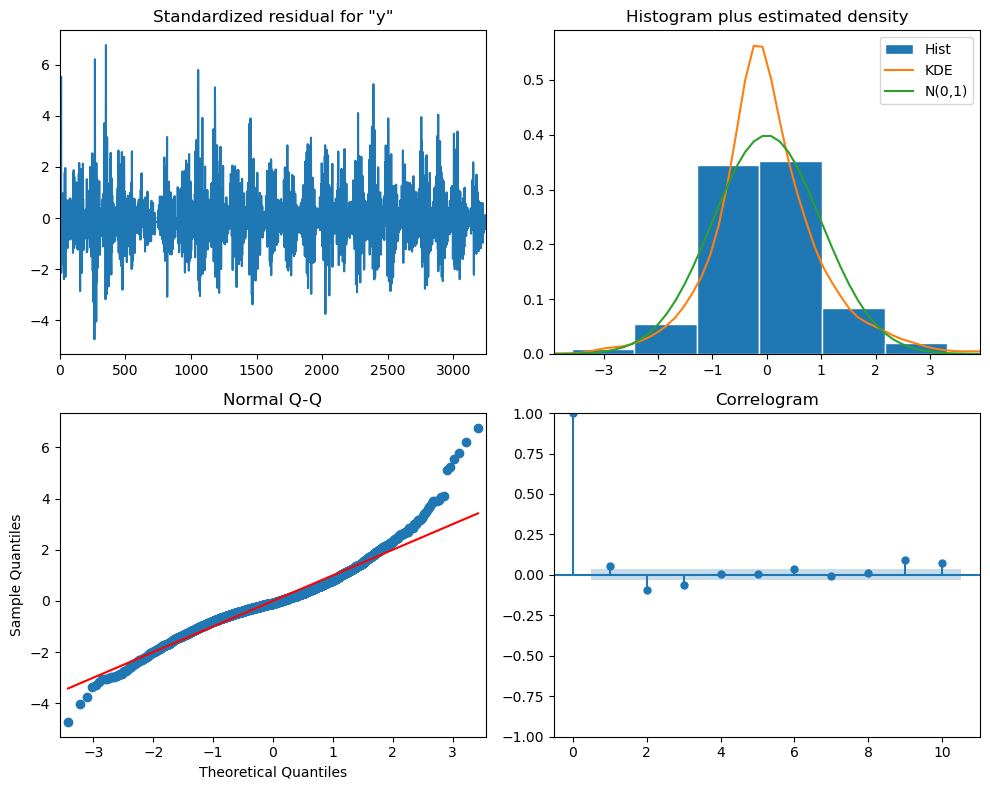

In [10]:
# Diagnostic plots for the model, including residuals and other model checks
res.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [11]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3252
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -15121.769
Date:                Fri, 02 May 2025   AIC                          30251.538
Time:                        14:48:23   BIC                          30275.886
Sample:                             0   HQIC                         30260.260
                               - 3252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         82.0696     14.033      5.848      0.000      54.566     109.573
ar.L1          0.9779      0.004    251.707      0.000       0.970       0.986
ma.L1         -0.4581      0.013    -35.256      0.000      -0.484      -0.433
sigma2       640.2085     10.058     63.653      0.000     620.496     659.921
===================================================================================
Ljung-Box (L1) (Q):                  10.16   Jarque-Bera (JB):              1794.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.64
Prob(H) (two-sided):                  0.53   Kurtosis:                         6.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Grid search with cross-validation for optimal p and q

In [12]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA
import warnings


data_array = data.values
avg_errors = []

for p in range(4):
    for q in range(4):
        errors = []
        tscv = TimeSeriesSplit(test_size=10)

        for train_index, test_index in tscv.split(data_array):
            X_train, X_test = data_array[train_index], data_array[test_index]
            X_test_orig = X_test.flatten()

            fcst = []

            for step in range(10):
                try:
                    mod = ARIMA(X_train, order=(p, 0, q))
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        res = mod.fit()
                    forecast_val = res.forecast(steps=1)[0]
                except:
                    forecast_val = np.nan

                fcst.append(forecast_val)

                # Update train and test
                X_train = np.concatenate((X_train, X_test[0:1]), axis=0)
                X_test = X_test[1:]

            fcst = np.array(fcst).flatten()

            if not np.isnan(fcst).any():
                errors.append(r2_score(X_test_orig, fcst))

        pq_result = [p, q, np.nanmean(errors)]
        print(pq_result)
        avg_errors.append(pq_result)

# Format as DataFrame
avg_errors = pd.DataFrame(avg_errors, columns=['p', 'q', 'error'])
result = avg_errors.pivot(index='p', columns='q', values='error')

[0, 0, -149.9431781594567]
[0, 1, -51.823569269635506]
[0, 2, -25.98274964187227]
[0, 3, -17.072654350935842]
[1, 0, -1.3017480138320088]
[1, 1, -0.400683619452779]
[1, 2, -0.3456145538122327]
[1, 3, -0.345893036269636]
[2, 0, -0.7249791416159126]
[2, 1, -0.3451795694529421]
[2, 2, -0.34581787631603744]
[2, 3, -0.339849265855715]
[3, 0, -0.5394148333836561]
[3, 1, -0.3436475878781183]
[3, 2, -0.5971768861820229]
[3, 3, -0.33668397755206014]


In [13]:
result

q,0,1,2,3
p,,,,
0,-149.943178,-51.823569,-25.982750,-17.072654
1,-1.301748,-0.400684,-0.345615,-0.345893
2,-0.724979,-0.345180,-0.345818,-0.339849
3,-0.539415,-0.343648,-0.597177,-0.336684


In [14]:
# Find the index of the maximum (least negative) R² value
best_p, best_q = result.stack().idxmax()
best_score = result.loc[best_p, best_q]

print(f"Best (p, q): ({best_p}, {best_q})")
print(f"R² score: {best_score:.4f}")

Best (p, q): (3, 3)
R² score: -0.3367


### Showing the test prediction of the final model

In [15]:
import warnings
warnings.filterwarnings("ignore")

data_array = data.values
X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = X_test

fcst = []

for step in range(10):
    mod = ARIMA(X_train, order=(10,0,9))
    res = mod.fit()
    fcst.append(res.forecast(steps=1))
    X_train = np.concatenate((X_train, X_test[0:1,:]))
    X_test = X_test[1:]

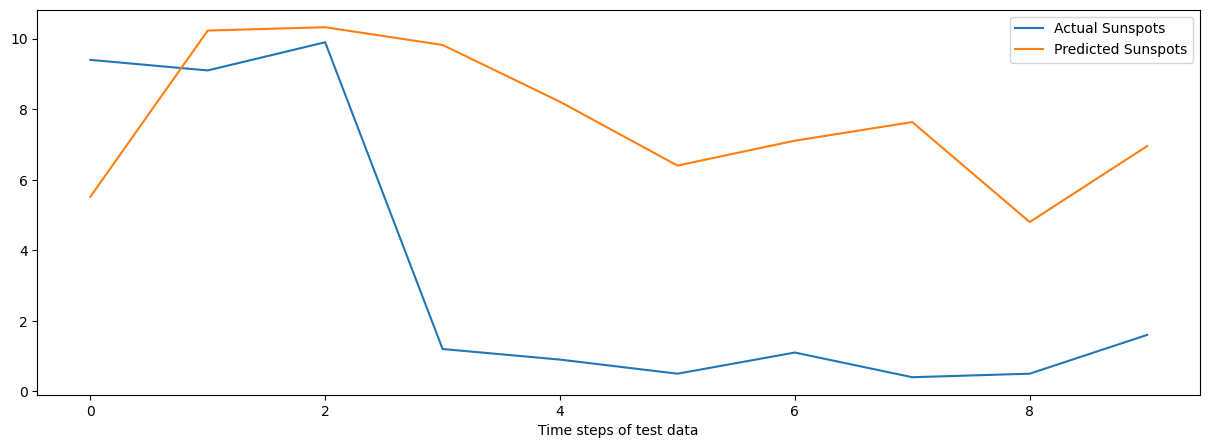

In [16]:
# Plot Graph
plt.figure(figsize=(15, 5))  
plt.plot(X_test_orig)
plt.plot(fcst)
plt.legend(['Actual Sunspots', 'Predicted Sunspots'])
plt.xlabel('Time steps of test data')
plt.show();

# 6. The ARIMA Model

In [17]:
import statsmodels.api as sm

data = sm.datasets.co2.load_pandas()
data = data.data
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


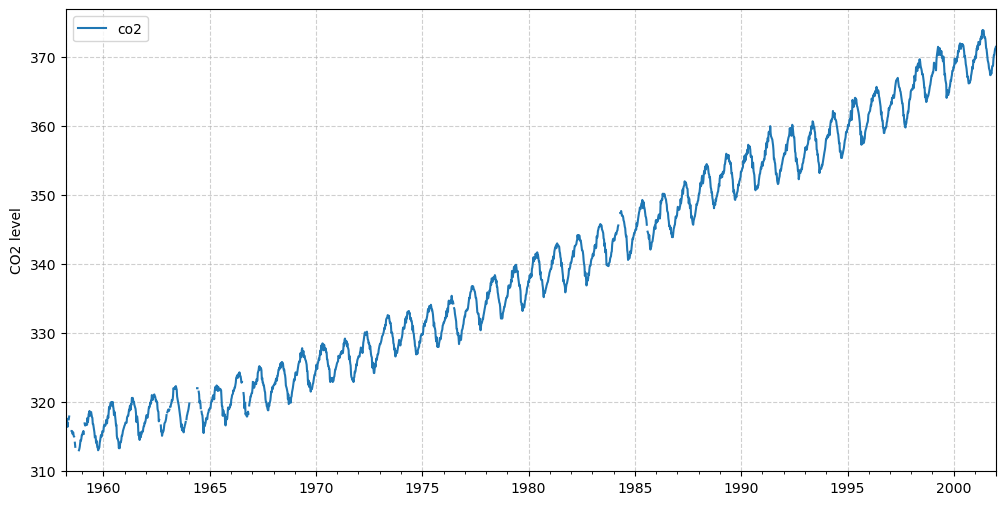

In [18]:
fig, ax = plt.subplots(figsize=(12, 6)) 
data.plot(ax=ax)                         
ax.set_ylabel('CO2 level')              
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

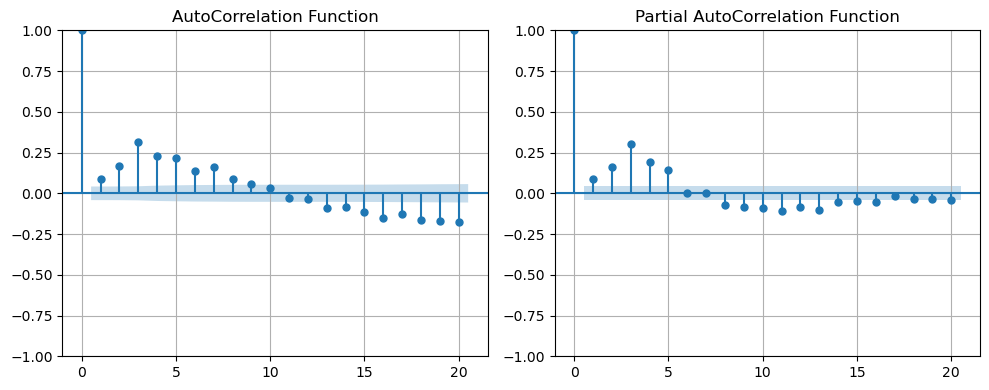

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(data.diff().dropna(), ax=axes[0], lags=20)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(data.diff().dropna(), ax=axes[1], lags=20)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

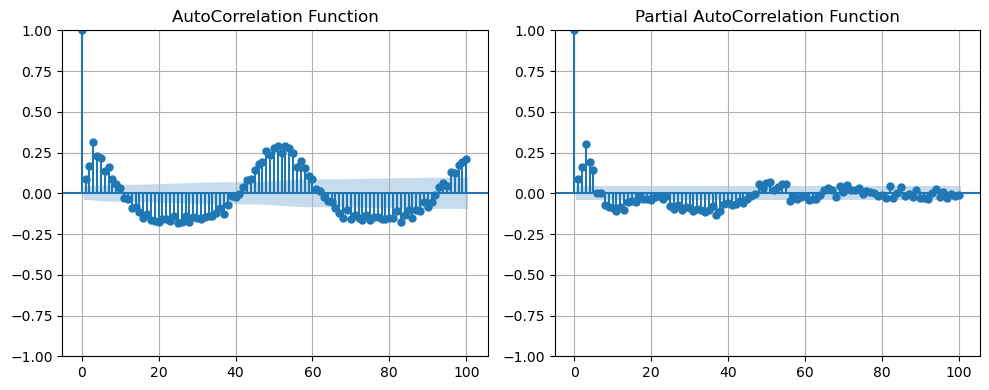

In [20]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(data.diff().dropna(), ax=axes[0], lags=100)
axes[0].set_title("AutoCorrelation Function", fontsize=12)
axes[0].grid(True)

# Simulated Random Walk Data
plot_pacf(data.diff().dropna(), ax=axes[1], lags=100)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [21]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit


data_array = data[['co2']].values

avg_errors = []

for p in range(4):
    for q in range(4):
        for i in range(2):
            errors = []

            tscv = TimeSeriesSplit(test_size=10)

            for train_index, test_index in tscv.split(data_array):

                X_train, X_test = data_array[train_index], data_array[test_index]
                X_test_orig = X_test

                fcst = []
                for step in range(10):

                    try:
                        mod = ARIMA(X_train, order=(p,i,q))
                        res = mod.fit()

                        fcst.append(res.forecast(steps=1))

                    except:
                        print('errorred')
                        fcst.append(-9999999.)

                    X_train = np.concatenate((X_train, X_test[0:1,:]))
                    X_test = X_test[1:]

                errors.append(r2_score(X_test_orig, fcst))

            pq_result = [p, i, q, np.mean(errors)]

            #print(pq_result)
            avg_errors.append(pq_result)

avg_errors = pd.DataFrame(avg_errors)
avg_errors.columns = ['p', 'i', 'q', 'error']
avg_errors.sort_values('error', ascending=False)

,p,i,q,error
23,2,1,3,0.723512
30,3,0,3,0.718654
15,1,1,3,0.716770
29,3,1,2,0.716186
13,1,1,2,0.715814
20,2,0,2,0.712195
31,3,1,3,0.711251
22,2,0,3,0.707708
27,3,1,1,0.706058
21,2,1,2,0.702519


In [22]:
X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = X_test

fcst = []

for step in range(10):

    mod = ARIMA(X_train, order=(4,1,4))
    res = mod.fit()
    fcst.append(res.forecast(steps=1))
    X_train = np.concatenate((X_train, X_test[0:1,:]))
    X_test = X_test[1:]

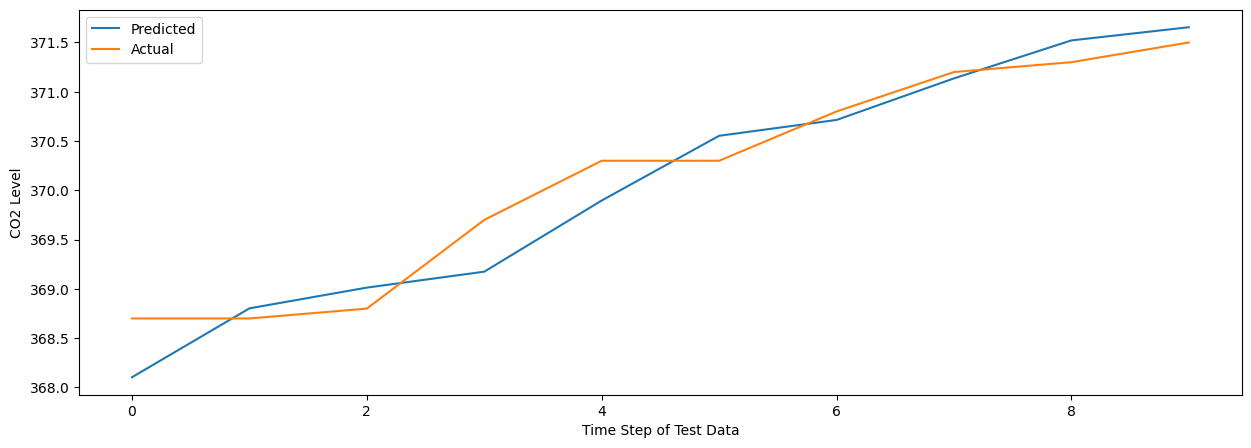

In [23]:
plt.figure(figsize=(15, 5)) 
plt.plot(fcst)
plt.plot(X_test_orig)
plt.legend(['Predicted', 'Actual'])
plt.ylabel('CO2 Level')
plt.xlabel('Time Step of Test Data')
plt.show();